In [2]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import glob
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# LULESH SPREADING ANALYSIS

In [52]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]

data = []

for spread in [1,8,16,20,24,28,32]:
    
    for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/lulesh_{spread}/lulesh_*.out')):

        with open(f, 'r') as fp:
            for line in lines_that_start_with("Elapsed time", fp):
                size = int(f.split('_')[-2])
                data.append([spread, size, float(line.split()[-2])])
                
lulesh_time = pd.DataFrame(data=data, columns=['spread', 'size', 'time'])
print(lulesh_time.loc[df['size'] == 10]['time'])

print()

8      9.7
16     9.0
22     9.5
23     9.7
25     9.4
      ... 
374    8.8
379    9.4
381    9.5
387    8.9
388    9.4
Name: time, Length: 70, dtype: float64



Text(0, 0.5, 'Time [s]')

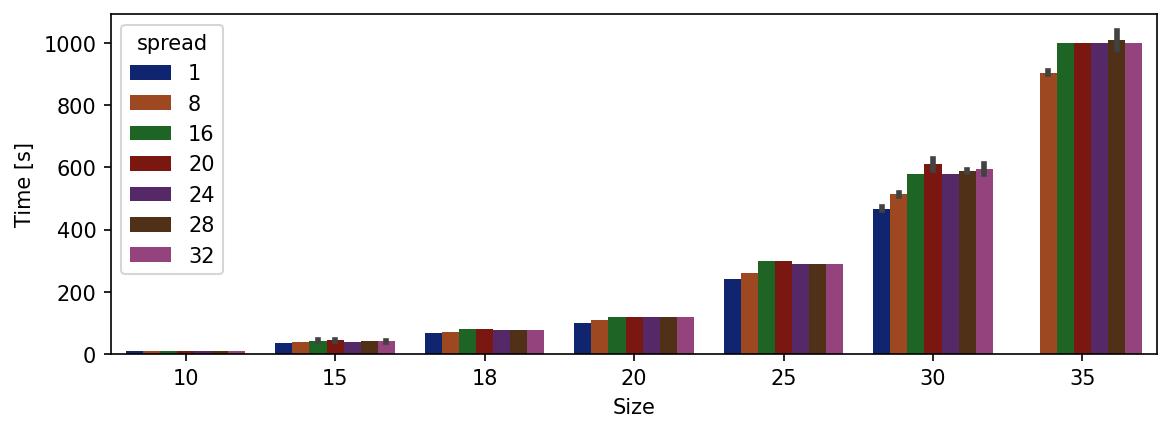

In [54]:
fig = plt.figure(figsize=(9,3))
ax = fig.gca()
g = sns.barplot(
    data=lulesh_time,
    x="size", y="time", hue="spread",
    ci="sd", palette="dark",#, alpha=.6, height=6,
    ax=ax
)
#g.despine(left=True)
ax.set_xlabel("Size")
ax.set_ylabel("Time [s]")
#g.legend.set_title("")


In [53]:
for size in [10,15,18,20,25,30]:
    mean_full = lulesh_time.loc[(df['size'] == size) & (df['spread'] == 32)].mean()
    mean_empty = lulesh_time.loc[(df['size'] == size) & (df['spread'] == 24)].mean()
    ratio = mean_full / mean_empty
    print(size, ratio['time'])

10 1.0270880361173815
15 1.0125
18 1.0182529335071706
20 1.0
25 1.0
30 1.0275862068965518


# NAS Benchmarks

In [51]:

def lines_that_contain(string, fp):
    return [line for line in fp if string in line]

data = []

for p in [1,2,4,8]:
    
    for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/nas_{p}/*.out')):
        #print(f)
        with open(f, 'r') as fp:
            for line in lines_that_contain("in seconds", fp):
                size = f.split('_')[-2]
                benchmark = f.split('_')[-3]
                data.append([p, benchmark, size, float(line.split()[-1])])

df_baremetal = pd.DataFrame(data=data, columns=['p', 'benchmark', 'size', 'time'])
mean_baremetal = df_baremetal.groupby(['benchmark', 'size', 'p']).mean()['time']
print('CoV', df_baremetal.groupby(['benchmark', 'size', 'p']).std()['time'] / mean_baremetal)

CoV benchmark  size  p
bt         A     1    0.018444
                 4    0.007384
           W     1    0.008760
                 4    0.018486
cg         B     4    0.007680
                 8    0.068124
ep         B     1    0.005324
                 2    0.114347
                 4    0.008996
                 8    0.175325
           W     1    0.023988
                 2    0.117849
                 4    0.210020
                 8    0.226589
ft         B     1    0.007854
                 2    0.006707
                 4    0.018033
                 8    0.071235
           W     1    0.053791
                 2    0.000000
                 4    0.000000
                 8    0.249981
lu         A     1    0.005579
                 2    0.003564
                 4    0.005517
                 8    0.018855
mg         B     1    0.006303
           W     1    0.000000
Name: time, dtype: float64


In [50]:

def lines_that_contain(string, fp):
    return [line for line in fp if string in line]

data = []

for p in [1,2,4,8]:
    
    for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/nas_sarus_{p}/*.out')):
        #print(f)
        with open(f, 'r') as fp:
            for line in lines_that_contain("in seconds", fp):
                size = f.split('_')[-2]
                benchmark = f.split('_')[-3]
                data.append([p, benchmark, size, float(line.split()[-1])])
                
df_container = pd.DataFrame(data=data, columns=['p', 'benchmark', 'size', 'time'])
df_container['type'] = df_container.apply(lambda row: f"({row['benchmark'].upper()}, {row['size']})", axis=1)
df_container.sort_values(by=['type'], inplace=True)
mean_container = df_container.groupby(['benchmark', 'size', 'p']).mean()['time']

print('Mean', mean_container)
print('CoV', df_container.groupby(['benchmark', 'size', 'p']).std()['time'] / sum_container)
print('Container/baremetal', sum_container/sum_normal)

Mean benchmark  size  p
bt         A     1    56.735
                 4    12.388
           W     1     1.959
                 4     0.543
cg         B     4    26.132
                 8     6.856
ep         B     1    18.800
                 2     9.448
                 4     4.808
                 8     2.664
           W     1     0.600
                 2     0.313
                 4     0.169
                 8     0.101
ft         B     1    38.975
                 2    24.010
                 4    12.973
                 8     7.527
           W     1     0.145
                 2     0.090
                 4     0.050
                 8     0.033
lu         A     1    26.044
                 2    13.425
                 4     6.883
                 8     4.074
mg         B     1     4.640
           W     1     0.125
Name: time, dtype: float64
CoV benchmark  size  p
bt         A     1    0.006726
                 4    0.010822
           W     1    0.006568
                 4   

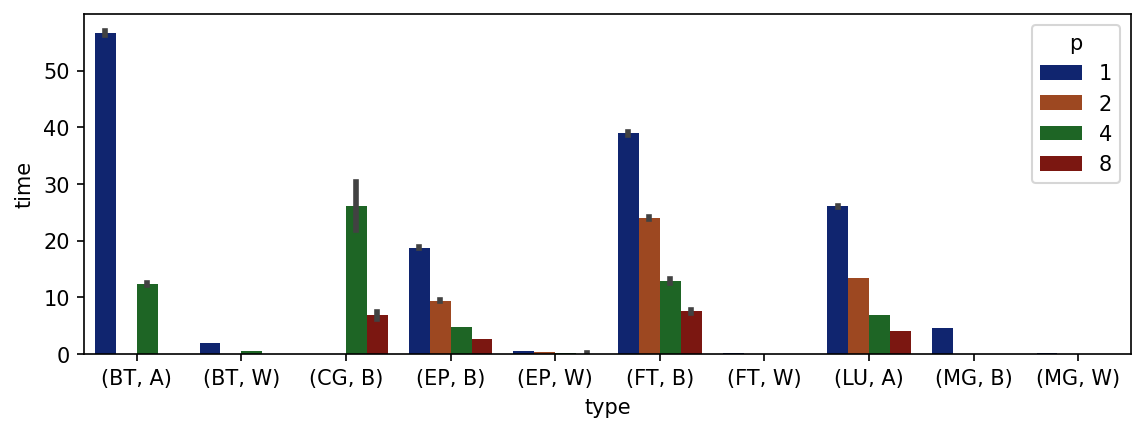

In [55]:
fig = plt.figure(figsize=(9,3))
ax = fig.gca()
g = sns.barplot(
    data=df_container,
    x="type", y="time", hue="p",
    ci="sd", palette="dark",#, alpha=.6, height=6,
    ax=ax
)
#g.despine(left=True)
#g.set_axis_labels("Size", "Time [s]")
#g.legend.set_title("")
